# Tutorial 2
## May 13, 2022

Last week, you've taken your first steps in PyTorch and trained your first (convolutional) neural networks. You know now what convolution and cross-correlation do and what the essential steps in training a network are.

This week, you will train convolutional neural networks for 2D image segmentation. Everything you do and learn here can be easily applied to 3D images. The data that we will be using today consists of chest X-ray images. The end goal in this dataset is to segment the ribs in these images, as in the image below. However, we will start a bit simpler and just segment every pixel that is a rib. As before, we indicate questions with ❓ and coding exercises with ⌨️.

<img src="https://vindr.ai/wp-content/uploads/2021/06/xrib-1.png.pagespeed.ic.yhPrlYfYEN.webp" width=600px></img>

Like last week, we first set the data path. We assume that you have put the images for Tutorial 2 in this path. If you're running this on Colab, don't forget to set a GPU runtime!

In [ ]:
# ONLY IF YOU USE JUPYTER: ADD PATH ⌨️
data_path = 'data/ribs'

In [ ]:
# # ONLY IF YOU USE COLAB: ADD PATH ⌨️
# from google.colab import drive

# drive.mount('/content/drive')
# data_path = r'/content/drive/My Drive/Tutorial2/ribs'

In [ ]:
# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["train", "val", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


<img src="https://i.imgur.com/KISYcqD.png" width=400px></img>
# Weights and Biases
In the previous tutorial, you have trained a neural network and monitored the loss curves in a Jupyter notebook. You can imagine that if you train multiple networks with different settings, it's easy to lose track of all loss curves and figure out which model is best. Luckily, there exist excellent so-called MLOps systems to keep track of your experiments. Examples are Tensorboard, Neptune, and Weights & Biases (wandb). Here, we will give you some tips on how to use this last one to keep track of your experiments. Setting everything up is a simple process:

1. Register an account at https://wandb.ai/site. Your projects and runs will be shown on this website, which is accessible from anywhere.

2. Run the cell below (including ```wandb.login()```) to sign into your account. You will have to paste an API key, which you can find at https://wandb.ai/authorize, and hit Enter.

In [ ]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.8 MB 12.4 MB/s            
     |████████████████████████████████| 181 kB 143.3 MB/s            
     |████████████████████████████████| 145 kB 140.7 MB/s            
     |████████████████████████████████| 63 kB 9.5 MB/s              
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=ed3e18a6152c442bd70294dd6fed6ec8373dfb07aa23fdfcd3202e177d4807a0
  Stored in directory: /home/baris/.cache/pip/wheels/54/4e/28/3ed0e1c8a752867445bab994d2340724928aa3ab059c57c8db
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b776b9a2924be526d59acd5cc4b2bd14c8a9bae075d9b8230931c65e11e44848
  Stored in directory: /home/baris/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built promise pathtools
  Consider adding this directory to PATH or, if you prefer to suppress this 

In [ ]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tutorial2_Segmentation_student.ipynb"

import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/baris/.netrc


True

Now, we can initialize a run in wandb with ```wandb.init()```. You can specify the project and run name, as well as configuration settings, by passing these as additional arguments.

In [ ]:
run = wandb.init(project='Example project', name='Example run', config={'dataset': 'ribs'})

wandb: Currently logged in as: barisimre (cpl57). Use `wandb login --relogin` to force relogin


By running the code above, a new run is created. Although we have not logged any information yet, it is possible to see the run on the wandb website. As soon as we will start logging information, it will become visible. It is possible to log information to your run with ```wandb.log()```. When it's time to complete the run, you can stop it with ```run.finish()```. Run the cell below and see what happens on the run webpage.

In [ ]:
import random
import time

for step in range(60):
    wandb.log({'Loss': random.random(), 'Accuracy': random.random()})
    time.sleep(1)
    
run.finish()

Accuracy,███▇▂▆▅▇▆▅█▅▅▅▂▁▇▂▅▄▃▄▇▅▄▇▄▃▁▇▂▇▅▃▄▆▅▃▂▅
Loss,▆▇▂▃▂▂▇▂▇█▁▃▆▃▁▆▃▇▁▆▆▂▂▂▆▄▅▁▆▇▄▆█▅▁▄▅█▆▄
Accuracy,0.5558
Loss,0.38693


In the remainder of this notebook, we will use wandb to log our loss values to a run webpage. In this way, it is easier to keep track of multiple losses and to compare several runs.

# Part 1: Segmentation of chest X-ray images
In this part of the tutorial, you will train a convolutional neural network for automatic segmentation of ribs in a chest X-ray image. You will examine the effects of using different loss functions, data augmentations and network architectures. To keep track of all these parameters, we will use wandb.

## Data management 

### Build a CacheDataset

At the beginning of the notebook, you defined the path to the rib data. We will know use it to find and load the corresponding images.
The data (similar to last week) consists of an image and a label. However, the label is in this case not a binary label, but a segmentation mask. Both the segmentation masks and the X-rays are .png files and can be opened using the PIL library.

For this tutorial we are not going to code the Dataset class ourselves but instead use a Monai class: [`CacheDataset`](https://docs.monai.io/en/stable/data.html#cachedataset). It has two main advantages:
- as the name suggests, it uses a [cache](https://en.wikipedia.org/wiki/Cache_(computing)) mechanism, which means that it is memory efficient (this is partly explained later).
- everything is pre-built, so no need to code the `__init__`, `__getitem__` and `__len__` functions anymore. 

`CacheDataset` only needs the list of your data samples to work. As we are learning a segmentation task, one data sample is composed of two images: the chest X-ray (named `img`) and the mask of the ribs (named `mask`). With Python, we represent this data sample with a dictionary:

<img src="https://i.imgur.com/yLI4sJz.png" alt="sample" width="450"/>

Then we could give this kind of list to `CacheDataset` to create our data set:

<img src="https://i.imgur.com/r7JJTgY.png" alt="list of samples" width="500"/>


However, as this list contains all the images, it means that all the images are always in Python memory even though they are not currently used so this is very inefficient. This is why we don't directly give  the images to `CacheDataset`, but the paths to find them on our disk. Then we also need to give a `Transform` object, `LoadRibData` which will transform these paths into the corresponding images only when they are needed.

<img src="https://i.imgur.com/JacrPFO.png" alt="list of paths" width="650"/>


<img src="https://i.imgur.com/EUWJj4r.png" alt="transform path to image" width="430"/>

As we don't want to write this list of paths manually, we write the function `build_dict_ribs` which automatically computes it based on the root folder of the data directory `data_path`. This is possible because fortunately your teachers pre-organized the dataset for this tutorial, but be aware that most medical datasets require a lot of cleaning up prior to this.

In [ ]:
!pip install monai

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch

def build_dict_ribs(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train', 'val' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all .png files in directory, including the path
    paths_xray = glob.glob(os.path.join(data_path, mode, 'img', '*.png'))
    # make a corresponding list for all the mask files
    for xray_path in paths_xray:
        if mode == 'test':
            suffix = 'val'
        else:
            suffix = mode
        # find the binary mask that belongs to the original image, based on indexing in the filename
        image_index = os.path.split(xray_path)[1].split('_')[-1].split('.')[0]
        # define path to mask file based on this index and add to list of mask paths
        mask_path = os.path.join(data_path, mode, 'mask', f'VinDr_RibCXR_{suffix}_{image_index}.png')
        if os.path.exists(mask_path):
            dicts.append({'img': xray_path, 'mask': mask_path})
    return dicts

class LoadRibData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = Image.open(sample['img']).convert('L') # import as grayscale image
        image = np.array(image, dtype=np.uint8)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        mask = np.array(mask, dtype=np.uint8)
        # mask has value 255 on rib pixels. Convert to binary array
        mask[np.where(mask==255)] = 1
        return {'img': image, 'mask': mask, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

> Note that LoadRibData is now outputing a much more complex dictionary with two additional keys: `img_meta_dict` and `mask_meta_dict`. These contain respectively the meta data of `img` and `mask`: here we decided to add the resolution of the image, corresponding to the key `affine`. This will be useful for Monai to perform some transformations later.

In the end `CacheDataset` needs two arguments to perform our procedure
1. The list of samples (represented by dictionaries) which is computed by `build_dict_ribs`.
2. A transform object, `LoadRibData`, which will transform the paths in the previous list into images.

In [ ]:
# construct list of dictionnaries
train_dict_list = build_dict_ribs(data_path, mode='train')
# construct CacheDataset from list of paths + transform
train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadRibData())

Loading dataset: 100%|█████████████| 195/195 [00:04<00:00, 41.18it/s]


> ❓ How many samples are in the training, validation and test datasets?

In [ ]:
len(train_dict_list)

195

> ❓ What are the dimensions of the images? Are they all equal? Will this a problem when training a CNN for segmentation?

In [ ]:
for x in train_dataset:
    pass
    # print(x['img'].shape)
    # print(x['mask'].shape)

> ❓ What is the pixel intensity range of the images? Are they similar? Will this be a problem when training a CNN for segmentation?

In [ ]:
for x in train_dataset:
    pass
    # plt.hist(x['img'].flatten())
    # plt.show()

#visualize the pixel intensity range of a bunch of images 
# hint: use matplotlib hist: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.hist.html
# 2nd hint: .flatten() your image (or you will get >2000 histograms per image)

### Image visualization

We now build `visualize_rib_sample` to plot X-ray images on which we overlay their binary mask (in green).

In [ ]:
def visualize_rib_sample(sample, title=None):
    # Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    plt.figure(figsize=[10,7])
    plt.imshow(image, 'gray')
    overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    plt.imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    if title is not None:
        plt.title(title)
    
    plt.show()

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b> Exercise</b>: Use <code>visualize_rib_sample</code> to visualize samples from the training set.
</div>

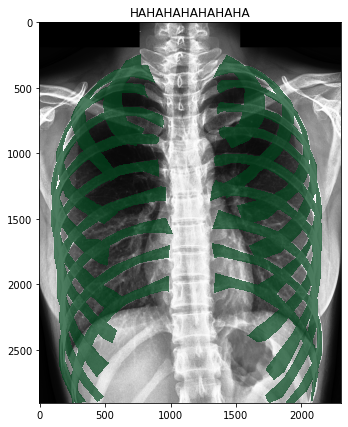

In [ ]:
visualize_rib_sample(train_dataset[15], title="HAHAHAHAHAHAHA")

### Data transforms

The training dataset that you have created in the previous step is quite small. In order to improve the generalization of the network, we are going to do some __data augmentation__. This can be easily implemented in the pipeline using the [transforms](https://docs.monai.io/en/stable/transforms.html#) in Monai. 

Monai distinguishes *deterministic* and *random* transforms:
- *Deterministic* transforms do the exact same thing every time they are called, for example intensity normalization will always have the same outcome. 
- *Random* transforms can be rotations or flips that do not have the same outcome each time they are called.

The random transforms (for example flipping and rotation) need to be performed in the same way on the input image `'img'` as well as on the label `'mask'`. Monai has [adapted transforms](https://docs.monai.io/en/stable/transforms.html#dictionary-transforms) that take dictionaries as an input, such that random transforms can be performed in the same way for both images: you don't want a different angle of rotation for the image and the mask, as they will become misaligned!

<img src="https://i.imgur.com/I7BErgj.png" alt="rotated sample" width="650"/>

_The examples below show how to use one of these dictionary transforms to perform a random horizontal flip and a random rotation:_
The procedure of applying a transform from Monai consists of two steps:
1. Initialize the transform: here you build the object and pass the init variables, such as the probability or range of rotation, and in case of a dictionary transform the keys of the dictionary.
2. Apply the transform on a data sample

Lastly: most transforms expect a channel dimension for both 2D and 3D images. As we have only one channel, we should add this extra dimension using the <code>monai.transforms.AddChanneld</code> transform first.


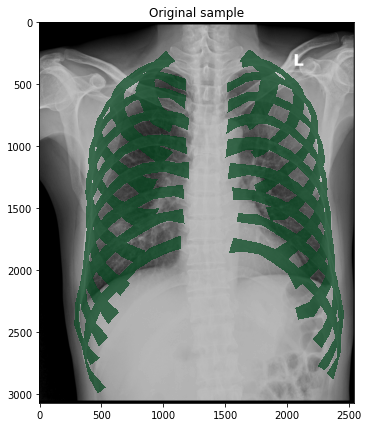

Size of the image before AddChanneld transform (3072, 2540)
Size of the image after AddChanneld transform (1, 3072, 2540)


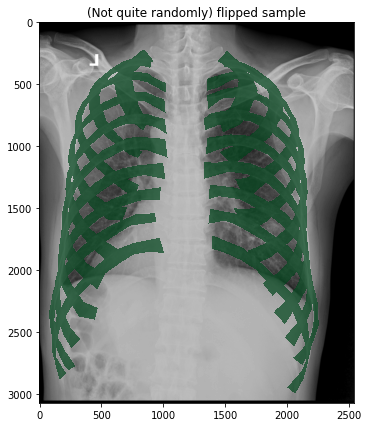

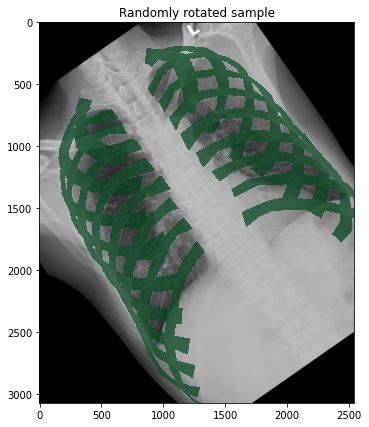

In [ ]:
# Load sample
index = np.random.choice(np.arange(len(train_dataset))) # This picks a random sample, but you can change this value
sample_dict = train_dataset[index]
visualize_rib_sample(sample_dict, title="Original sample")

# Add channels
add_channels_transform = monai.transforms.AddChanneld(keys=['img', 'mask']) # Initialize the transform
channels_sample_dict = add_channels_transform(sample_dict) # Apply the transform
print("Size of the image before AddChanneld transform", sample_dict["img"].shape)
print("Size of the image after AddChanneld transform", channels_sample_dict["img"].shape)

# Random flip
# here we define the keys, the probability that the flip is performed and the axis to flip over
random_flip_transform = monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1, spatial_axis=1)
# We put a probability of 1 to always flip the image for visualization purposes.
# Please DO NOT DO THAT in the rest of the notebook.
flipped_sample_dict = random_flip_transform(channels_sample_dict)
visualize_rib_sample(flipped_sample_dict, title="(Not quite randomly) flipped sample")

# Random rotation
# Here we define the keys in the dictionary that contain the data, the rotation range, but also the interpolation mode. 
# The interpolation mode defines how new pixel values for the rotated image are computed. 
# Note that these differ between mask and image, as we want to keep binary labels for the masks, and (bi)linear interpolation
# would result in scalar values between 0 and 1.
random_rotation_transform = monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest'])
rotated_sample_dict = random_rotation_transform(channels_sample_dict)
visualize_rib_sample(rotated_sample_dict, title="Randomly rotated sample")

Note how we concatenated the `AddChannelsd` transform with the flip and rotate transform by applying them after each other. If we have only two transforms, like here, this is an acceptable workflow. However, if we have a whole bunch of transforms that we have to call during training of the network, you can imagine that the code will become very messy. Therefore, we can combine multiple transforms into a single one using [<code>monai.transforms.Compose</code>](https://docs.monai.io/en/stable/transforms.html#compose).

Upon initialization, `Compose` takes a list of transforms as input and outputs a transform object that concatenates all the transforms. It can be applied in the same way as the transforms shown above.

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b> Exercise</b>: Use the <code>Compose</code> class of Monai to compose <code>AddChanneld</code>, <code>RandFlipd</code> and <code>RandRotated</code> in a single transform. Then apply this composition to a data set sample.
</div>

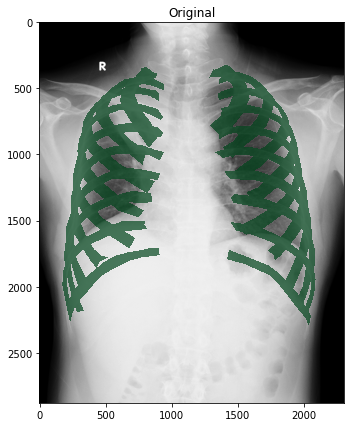

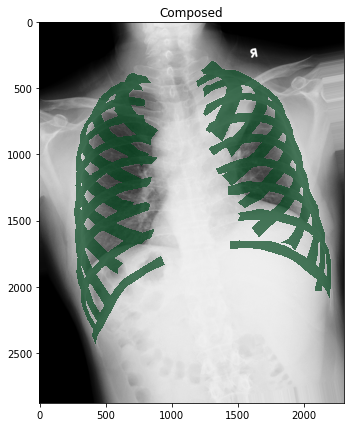

In [ ]:
sample_dict = train_dataset[0]
visualize_rib_sample(sample_dict, "Original")

compose_transform = monai.transforms.Compose([add_channels_transform, random_flip_transform, random_rotation_transform])

sample = train_dataset[0]
composed_sample = compose_transform(sample)
visualize_rib_sample(composed_sample, "Composed")


As mentioned before, there is a distinction between random and deterministic transforms. This distinction is important, as their order can have a huge influence on computational efficiency. The [CacheDataset](https://docs.monai.io/en/stable/data.html#cachedataset) class stores the outcomes of all deterministic transforms in memory, and performs the random transforms on-the-fly. Therefore, placing the deterministic transforms before the random ones in combination with caching results in a training and inference procedure will result in higher computational efficiency.

> ❓ Which transforms can you safely use for augmentation in the X-ray segmentation task?

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: Compose these transforms in a computationally efficient order and construct a new training dataset using them.
    
  1. Make sure to visualize some samples to see if the transforms are working as you expect.
    
  2. Don't forget to put <code>LoadRibData</code> as your first transform or your dataset will try to rotate strings representing the paths of your images...
    
  3. If you identified problems in the previous sections it is time to solve them!
</div>

In [ ]:
## Add your transforms here! We provide three useful ones
train_transform = monai.transforms.Compose(
    [
        LoadRibData(),
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1), # Rescales intensities from [0-255] to [0-1]
        compose_transform,
        monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']), # Make the image four times smaller
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=[256,256], random_size=False) # Crops a patch of 256x256 pixels
    ]
)



train_dataset = monai.data.CacheDataset(train_dict_list, transform=train_transform)

Loading dataset: 100%|█████████████| 195/195 [00:05<00:00, 32.67it/s]


### Intermezzo: Remember your transforms

To keep track of the transforms and other parameters used and their effect on the model, it is clever to log all the settings in wandb.
This can be done using the <code>config</code> argument of `wandb.init`, that is called before training the model. This argument takes a dictionary (or nested dictionary) to save your settings in.

Unfortunately we cannot give our transforms "as such" to the W&B configuration parameter... This is why we will transform our composition of transforms with the function `from_compose_to_list`. This function takes the composed transform and outputs a dictionary that contains all the used transforms and their settings. Alternatively, you can construct a (nested) dictionary containing all this information and pass it to <code>wandb.config</code>. 

The second function `from_list_to_compose` is meant to do the reverse, i.e. go from the dictionary resulting from `from_compose_to_list` back to the composed transform that can be applied on the data samples.

In [ ]:
def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """
    
    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")
    
    pre_compose_list = list()
    
    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")
        
        try:
            transform = transform_dict['class'](**transform_dict['kwargs'])
        except TypeError: # Classes have been converted to str after saving
            transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])
            
        pre_compose_list.append(transform)
        
    return monai.transforms.Compose(pre_compose_list)

### Dataloader

We use mini-batch gradient descent during training, so we want to sample batches to train the network on, rather than single instances of the data. For this, like last time, we use <code>monai.data.DataLoader</code>, which efficiently samples batches from the data that can be fed into the network right away.

This [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) provides more information about datasets and dataloaders.

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: 
    Construct a dataloader with randomly sampled mini-batches of 16 images for the training set
</div>

In [ ]:
train_dataloader = monai.data.DataLoader(train_dataset, batch_size=16, num_workers=4)

### Validation set
During training, we want to keep an eye on how the network generalizes to unseen data. It could perform very well on its training set, whereas it performs poorly on unseen data (overfitting). For this, we need to construct a validation set consisting of comparable but different samples of data than the training set. For our data, it can be constructed in a similar way as the train set:
1. Construct the dictionary of file paths
2. Define the transforms that should be applied on the validation data
3. Construct the CacheDataset using the dictionary and transform
4. Build a validation dataloader using from the CacheDataset

In contrast to the training set, we don't apply data augmentation to the validation set. This is important to keep in mind when defining transforms.
<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: 
    Build a validation dataset and dataloader using these steps. Create a separate validation transform.
</div>

Loading dataset: 100%|███████████████| 24/24 [00:00<00:00, 28.14it/s]


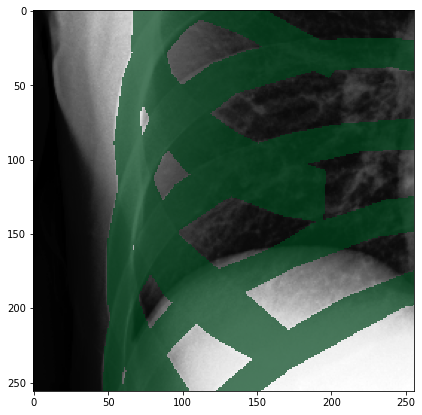

numpy.ndarray

In [ ]:
# construct list of dictionnaries
test_transform = monai.transforms.Compose(
    [
        LoadRibData(),
        add_channels_transform,
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1), # Rescales intensities from [0-255] to [0-1]
        monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']), # Make the image four times smaller
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=[256,256], random_size=False) # Crops a patch of 256x256 pixels
    ]
)
test_dict_list = build_dict_ribs(data_path, mode='test')
test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_dataloader = monai.data.DataLoader(test_dataset, batch_size=1, num_workers=4)
visualize_rib_sample(test_dataset[0])
type(test_dataset[0]['img'])

## Setting up the neural network, loss function, and optimizer

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="600"/>

Now that we have the data loading process out of the way, we set up a U-Net, a loss function, and an optimizer. If possible, use a GPU to substantially speed up computing.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


Setting up a [U-Net](https://arxiv.org/abs/1505.04597) for segmentation in MONAI is as easy as calling the `UNet` function and providing it with the number of input channels, output channels, and feature maps/channels in the intermediate layers. The following provides us with a model that is optimized during training to perform segmentation.

In [ ]:
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels = (8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: 
    How many levels does the U-Net have? And how many parameters does it have (use the code from last tutorial)? 
</div>

In [ ]:
# 

### Loss function

The loss function should reflect what we want the training model to be able to do. 
For segmentation, a popular function to use for training the network is the [Dice loss](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), which measures the overlap between the ground-truth and the model prediction. Monai offers a wide range of different [loss functions](https://docs.monai.io/en/stable/losses.html) that are also suitable for segmentation. In this tutorial, we will also assess the effects of using different loss functions on our network performance.

We show how to implement the Dice function in this example. Our network only has one output channel. In order to have all the output values between 0 and 1, so we can compute the Dice, the function first applies a [logistic sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). The Dice loss is computed over the full mini-batch (`batch=True`) to avoid poorly defined loss in individual batch samples. This means that, in a sense, we compute the Dice loss in a 3D stack of 2D images.

In [ ]:
loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)

### Choose an optimizer

An optimizer algorithm is chosen that performs gradient descent on the network parameters to minimize the loss function. Last week you have used SGD, stochastig gradient descent. In many cases, [Adam](https://arxiv.org/abs/1412.6980) is a good default option. The optimizer operates on the parameters of the previously defined U-Net, i.e. `model`. A learning rate `lr` is provided to the optimizer, which defines how large the changes should be that are made to the network parameters in each iteration.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Setting up the training loop
In the previous tutorial, we explained how to set up a simple loop for training your network. For training this network, the loop can be set up in a similar way.
Instead of keeping track of the train and validation loss on your computer, you can [log](https://docs.wandb.ai/guides/track/log) everything in weights and biases.

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: 
Set up a simple loop for training the network and log the following in weights and biases:
    
- Loss function
- Learning rate
- Training loss
- Validation loss
- Some validation images, including segmentation masks that display model output and the ground truth (see [W&B documentation](https://docs.wandb.ai/guides/track/log/media#image-overlays)).
</div>

Below, we provide a ```log_to_wandb()``` function that you could use for this. Just call it once at the end of every epoch, with the right arguments.

In [ ]:
from tqdm import tqdm
import wandb

run = wandb.init(
    project='tutorial2_segmentation',
    name='test',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'transform': from_compose_to_list(train_transform),
        'batch_size': train_dataloader.batch_size,
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should add information on your model...

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    sigmoid = torch.nn.Sigmoid()
    mask_output = sigmoid(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'ribs'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    
for epoch in tqdm(range(200)):
    ### FILL IN ###
    losses = []
    val_losses = []
    outputs = []
    
    for entry in train_dataloader:
        img = entry['img']
        mask = entry['mask']
        model.train()
        optimizer.zero_grad()
        output = model(img.to(device))
        loss = loss_function(output, mask.to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    batch_data ={'img': [], 'mask': []}
    outputs = []
    
    for entry in test_dataloader:
        img = entry['img']
        mask = entry['mask']
        model.eval()
        output = model(img.to(device))
        loss = loss_function(output, mask.to(device))
        val_losses.append(loss.item())
        batch_data['img'].append(img)
        batch_data['mask'].append(mask)
        outputs.append(output)
        
    train_loss = sum(losses) / len(losses)
    val_loss = sum(val_losses) / len(val_losses)
    
    ### FILL OUT ###
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)

# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
run.finish()

  8%|██▎                          | 16/200 [07:50<1:30:24, 29.48s/it]

# Part 2: Evaluate the trained network

## Visual inspection
We have trained the network on small patches of the image. In order to see how well it performs on the entire image, we can use the <code>monai.inferers.SlidingWindowInferer</code>. This 'slides' the network over patches of the input image. The overlap between patches can also be controlled. 

<img src="https://docs.monai.io/en/stable/_images/sliding_window.png"> </img>

oreover, we want our final mask to have discrete values (0 or 1). Then, we need to discretize the continuous output of the network. This is why we use `Sigmoid` (clipping the output values between 0 and 1) and `AsDiscrete` (mapping the continuous distribution on the {0, 1} set).

In [ ]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection the result of one sample by plotting 
    the X-ray image, the ground truth (green) and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256,256])
#     discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu())).squeeze()
    
    fig, ax = plt.subplots(1,3, figsize = [12, 10])
    
    # Plot X-ray image
    ax[0].imshow(sample["img"].squeeze(), 'gray')    
    ax[1].imshow(sample["img"].squeeze(), 'gray')
    # Plot ground truth
    mask = np.squeeze(sample['mask'])
    overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    ax[1].imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[1].set_title('Ground truth')
    # Plot output
    overlay_output = np.ma.masked_where(output < 0.1, output >0.99)
    ax[2].imshow(sample['img'].squeeze(), 'gray')
    ax[2].imshow(overlay_output, 'Reds', alpha = 0.7, clim=[0,1])
    ax[2].set_title('Prediction')
    plt.show()

In [ ]:
test_dict = build_dict_ribs(data_path, mode='test')
test_transform = monai.transforms.Compose([
        LoadRibData(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ]
)
test_set = monai.data.CacheDataset(test_dict, transform=test_transform)
test_loader = monai.data.DataLoader(test_set, batch_size=1)

for sample in test_loader:
    visual_evaluation(sample, model)

## Compute evaluation metrics

Previously, we evaluated the quality of our segmentation on the test set by visually inspecting the quality of the maps produced by our network. Though this is an essential step when developping and debugging a network, this step is also quite subjective, and tedious when there are a lot of images. This is why we need metrics to evaluate the performance of our network! These metrics give us a quantity that represents the performance of our network and enable comparison to other methods.

We provide the function `compute_metric` to evaluate the performance of the network on the segmentation task. Similar to the transforms and loss functions, Monai contains many [evaluation metrics](https://docs.monai.io/en/stable/metrics.html) to assess the model's performance. We show how to compute the Dice metric for the network.

In [ ]:
def compute_metric(dataloader, model, metric_fn):
    """
    This function computes the average value of a metric for a data set.
    
    Args:
        dataloader (monai.data.DataLoader): dataloader wrapping the dataset to evaluate.
        model (torch.nn.Module): trained model to evaluate.
        metric_fn (function): function computing the metric value from two tensors:
            - a batch of outputs,
            - the corresponding batch of ground truth masks.
        
    Returns:
        (float) the mean value of the metric
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256,256])
    discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    Sigmoid = torch.nn.Sigmoid()
    
    mean_value = 0
    
    for sample in dataloader:
        with torch.no_grad():
            output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu()))
        mean_value += metric_fn(output, sample["mask"])
    
    return (mean_value / len(dataloader)).item()

As we want to log everything in the corresponding run with W&B, we access to the corresponding run with `wandb.Api()`.

In [ ]:
api = wandb.Api()
run = api.run(f"tutorial2_segmentation/{run_id}")

### Dice

This is the same metric that the one that was used for the loss function.

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: Find the appropriate function in <a href="https://docs.monai.io/en/stable/metrics.html"><code>monai.metrics</code></a> to compute the mean Dice with <code>compute_metric</code>.

</div>

In [ ]:
metric_fn = #
dice = compute_metric(test_loader, model, metric_fn)
run.summary["dice"] = dice
print(f"Dice on test set {dice}")

### Hausdorff distance

The Hausdorff distance uses a function f which computes the minimal distance between the farthest point that can be found in a set Y compared to another set X. The Hausdorff takes the worst case between f(X,Y) and f(Y,X).

<img src="https://i.imgur.com/V7XL8eU.png" alt="illustration of Hausdorff distance from Wikipedia" width="200"/>


<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: Find the appropriate function in <a href="https://docs.monai.io/en/stable/metrics.html"><code>monai.metrics</code></a> to compute the Hausdorff distance with <code>compute_metric</code>.

</div>

In [ ]:
metric_fn = # 
Hausdorff_dist = compute_metric(test_loader, model, metric_fn)
run.summary["Hausdorff_dist"] = Hausdorff_dist
print(f"Hausdorff distance on test set {Hausdorff_dist}")

> ❓ Are you happy with the performance of your model? 

> ❓ Can you think of ways to improve the performance? Try to implement, train again, and compare in wandb!

## Comparison to baseline masks
Although you did some visual inspection of the outputs of the model, interpretation of the Dice scores and Hausdorff distances is [not trivial](https://arxiv.org/abs/2104.05642). Therefore, comparing to a baseline model for which we know it performs poorly is a good way to get some idea of how good your model actually is. 

For our dummy baseline model, instead of rib-shaped segmentations, we let the model output square segmentation maps in the rib region.

In [ ]:
from skimage import measure

def make_dummy_sample(sample):
    M = sample['mask'].squeeze()
    labels = measure.label(M)
    dummy_labels = np.zeros((labels.shape[0], labels.shape[1]))
    for i in np.unique(labels):
        if i > 0:
            mask_locs = np.where(labels == i)
            limits = [np.min(mask_locs[0]), np.max(mask_locs[0]), np.min(mask_locs[1]), np.max(mask_locs[1])]
            dummy_labels[limits[0]:limits[1], limits[2]:limits[3]] = 1
    return torch.tensor(dummy_labels)

In [ ]:
sample = test_set[0]
visualize_rib_sample(sample, title = 'original mask')
visualize_rib_sample({'img': sample['img'], 'mask': make_dummy_sample(sample)}, title = 'dummy segmentation masks')

In [ ]:
def compute_metric_dummy(dataloader, metric_fn):
    """
    This function computes the average value of a metric for a data set using the dummy segmentation masks
    
    Args:
        dataloader (monai.data.DataLoader): dataloader wrapping the dataset to evaluate.
        metric_fn (function): function computing the metric value from two tensors:
            - a batch of outputs,
            - the corresponding batch of ground truth masks.
        
    Returns:
        (float) the mean value of the metric
    """
    
    mean_value = 0
    A = monai.transforms.AddChannel()
    
    for sample in dataloader:
        output = make_dummy_sample(sample)
        mean_value += metric_fn(A(A(output)), sample["mask"])
    
    return (mean_value / len(dataloader)).item()

In [ ]:
print(compute_metric_dummy(test_loader, monai.metrics.compute_meandice))

> ❓ Are you still happy with the performance of your model? 

> ❓ Can you think of other baseline you can compare to? 

# Part 3: Multilabel classification

<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  ⌨ <b>Exercise</b>: In the data directory, we have also placed a folder called 'mask_mc' for the train, val and test set. In these images, we have labeled the left and right 7th rib. This is one of the ribs that's most prone to fracture, and identifying exactly that rib and the side that it's on could be valuable. Thus, this is no longer a binary label segmentation problem, but a multiclass segmentation problem. Try to also segment these images, consider what you will have to change in your code for this to work. Note that in the mask_mc images, pixels with label 1 have value 127 and pixels with label 2 have value 255.

</div>


In [ ]:
# ⌨